In [1]:
import os
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import tensorflow_recommenders as tfrs

import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

# Описание задачи

Существует база несчастный случаев, которые регистрирует инспеция труда. О каждом случае имеется подробная информация о деталях несчастного случая.

Задачей является применение нейронных сетей для предсказания наиболее вероятной причины несчастного случая, основываясь на реальных знаниях и статистике.

In [2]:
df = pd.read_excel('database.xlsx')
df.head()

,№ НС п/п,Пол,Семья,Тяжесть последствий,Дата происшествия,месяц НС,Видпроисшествия,Причина,Время суток,Алкоголь,...,Дата проверки знаний,Образование,УТ,СОУТ/АРМ (Дата),ОВПФ,Доп. инфо,День недели НС,время после (в днях),Время после проверкизнаний(вднях),ОКВЭД/отрасль
0,1.0,муж.,женат,Смерть,2016-05-31,май,19.0,19,17 ч. 00 м,нет,...,2015-08-28,НП,2.0,2013.0,"х, м, т, н",гипертоническа болезнь,вторник,50.0,273,01.23
1,2.0,муж.,женат; иждив.: нет,Смерть,2007-10-29,октябрь,19.0,15,15 ч. 30 м,нет,...,NaT,среднее,,NaN,,ишемическая болезнь сердца,понедельник,720.0,NaN,45.31
2,3.0,муж.,не женат; иждив.: нет,Смерть,2007-10-08,октябрь,2.0,"9, 10, 13",19 ч. 30 м,да,...,NaT,,,NaN,,смерть наступила от травматического шока на фо...,понедельник,94.0,NaN,45.21.1
3,4.0,муж.,женат; иждив.: нет,Тяжелый,2007-09-12,сентябрь,4.0,"16, 17",16 ч. 55 м,нет,...,2007-08-20,среднее,,NaN,,открытый оскольчатый депрессионный перелом лев...,среда,810.0,690,40.10.2
4,5.0,муж.,женат; иждив.: 1,Тяжелый,2007-09-28,сентябрь,2.0,"11, 16",16 ч. 30 м,нет,...,NaT,среднее,,NaN,,закрытый оскольчатый перелом тела третьего поз...,пятница,660.0,NaN,45.21.1


In [3]:
df.shape

(912, 34)

Данные представляют собой файл из 912 несчастных случаев, произошедших с 2007 по 2018 год в Белгородской области.

## Исследование данных

В данных мало информации о легких несчастных случаях, так как работадатели предпочитают не говорить о них инспекции труда.

Из-за таких особенностей данных, задачей становиться предсказание причин смертельных и тяжелых несчастных случаев.

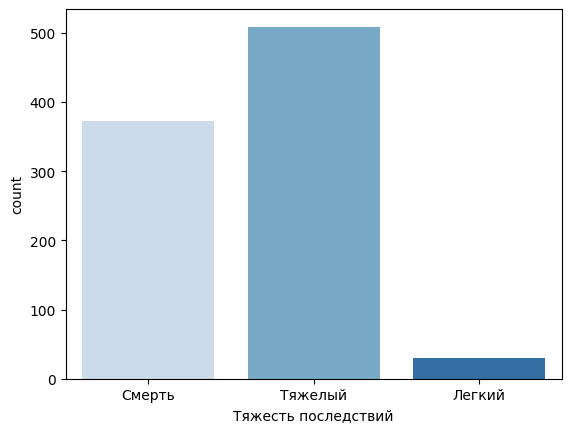

In [4]:
sns.countplot(x='Тяжесть последствий',data=df,palette='Blues' );

Наиболее частыми видами несчастных случаев являются:
* Падение пострадавшего с высоты
* Воздействие движущихся, разлетающихся, вращающихся предметов, деталей, машин и т.д., в т.ч.
* Общее заболевание, не связанное с производством

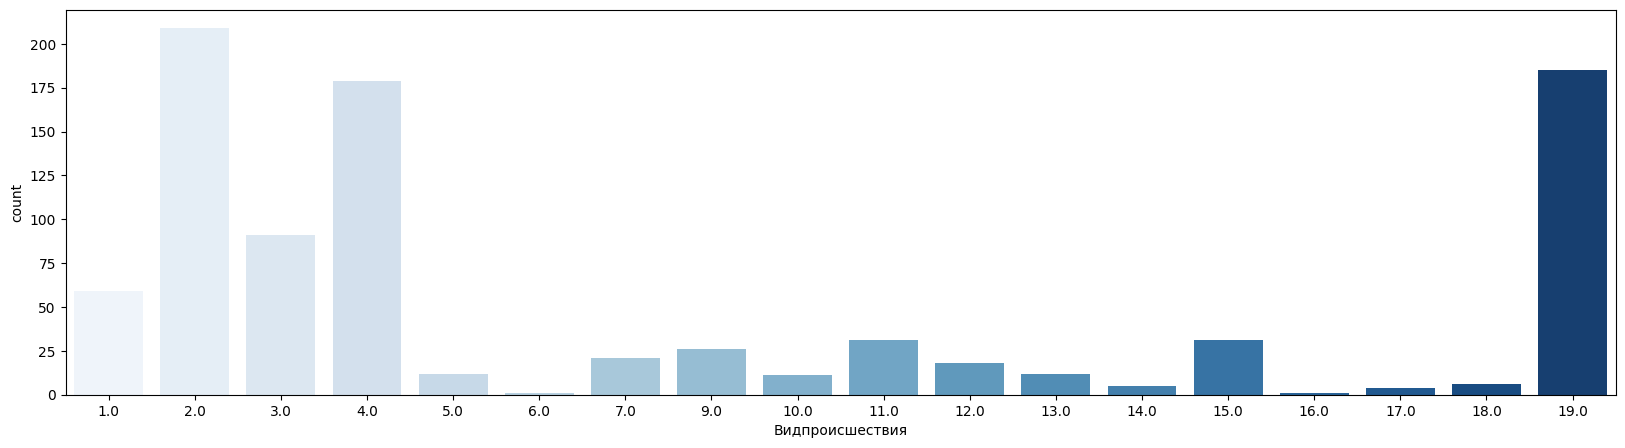

In [5]:
plt.figure(figsize=(20,5))
sns.countplot(x='Видпроисшествия',data=df,palette='Blues' );

## Очистка данных

Для легких несчастных случаев крайне мало информации чтобы построить статистическую модель.

Заболевания, не связанные с производством, также не помогут сложить общую картину для прогноза, они индивидуальны для каждого.

Легкие НС, а также вызванные заболеванием отфильтруем

In [6]:
df = df[df['Тяжесть последствий'] != 'Легкий']
df = df[df['Видпроисшествия'] != 19]
df.shape

(698, 34)

## Базовая модель

Базовая модель будет строить на предположении того, что для каждой отрасли есть свои характерные причины несчастных случаев.

In [7]:
data = df[['Причина', 'ОКВЭД/отрасль']].rename(columns={'Причина' : 'Reason', 'ОКВЭД/отрасль' : 'Industry'})
data.head(10)

,Reason,Industry
2,"9, 10, 13",45.21.1
3,"16, 17",40.10.2
4,"11, 16",45.21.1
6,7,65.11
7,7,74.20.36
8,"13, 17, 13",45.21.1
9,"8, 17",74.60
10,"8, 13",75.23.4
11,"4, 17",45.23.1
12,"5, 11, 16",18.13.1


Кодов ОКВЭД большое множество, для упрощения будет использовать только группу, к которой принадлежит производство.

In [8]:
def find_industry(x):
    if x <= '03':
        return 'Сельское и лесное хозяйство'
    elif x <= '09':
        return 'Добыча полезных ископаемых'
    elif x <= '33':
        return 'Обрабатывающие производства'
    elif x <= '35':
        return 'Обеспечение энергией'
    elif x <= '39':
        return 'Водоснабжение'
    elif x <= '43':
        return 'Строительство'
    elif x <= '47':
        return 'Торговля; Ремонт автотранспорта'
    elif x <= '53':
        return 'Транспортировка и хранение'
    elif x <= '56':
        return 'Деятельность гостиниц и предприятий общественного питания'
    elif x <= '63':
        return 'Деятельность в области информации'
    elif x <= '66':
        return 'Деятельность финансовая'
    elif x <= '68':
        return 'Деятельность с недвижимым имуществом'
    elif x <= '75':
        return 'Деятельность профессиональная'
    elif x <= '82':
        return 'Деятельность административная'
    elif x <= '84':
        return 'Государственное управление'
    elif x <= '85':
        return 'Образование'
    elif x <= '88':
        return 'Здравоохранения'
    elif x <= '93':
        return 'Культура и спорт'
    elif x <= '96':
        return 'Прочие виды услуг'
    elif x <= '98':
        return 'Деятельность домашних хозяйств как работодателей'
    elif x <= '99':
        return 'Деятельность экстерриториальных организаций'
    else:
        return 'nan'

Среди причин НС встречается сразу несколько. Сделаем каждую причину отдельной записью с присвоением ей группы по классификации ОКВЭД

In [9]:
Reasons_and_Industries_list = []
for index, row in data.iterrows():
    rsns = str(row[0]).split(', ')
    ind = str(row[1]).split('.')[0]
    ind = find_industry(ind)
    for rsn in rsns:
        Reasons_and_Industries_list.append([rsn, ind])
 

data = pd.DataFrame(Reasons_and_Industries_list, columns = ['Reason', 'Industry'])
data.head()

,Reason,Industry
0,9,Торговля; Ремонт автотранспорта
1,10,Торговля; Ремонт автотранспорта
2,13,Торговля; Ремонт автотранспорта
3,16,Строительство
4,17,Строительство


В данных присутствуют ошибки, так данные вводились вручную.

Среди причин встречаются 18, 19, которых нет среди кодов причин НС и они являются видами происшествий. Также встречаются данных, где пропушены значения причины НС и отрасль производства.

Эти данные также фильтруем

In [10]:
data = data[data['Reason'] != '19']
data = data[data['Reason'] != '18']
data = data[data['Reason'] != 'nan']
data = data[data['Industry'] != 'nan']

Коды причин несчастных случаев

In [11]:
reasons = pd.read_excel('database.xlsx', sheet_name='Коды причин НС', dtype={'Код': str})
reasons.rename(columns={'Наименование причины' : 'Reason_name', 'Код' : 'Reason'}, inplace=True)
reasons.head()

,Reason_name,Reason
0,Конструктивные недостатки и недостаточная наде...,1
1,Несовершенство технологического процесса,2
2,"Эксплуатация неисправных машин, механизмов, об...",3
3,Неудовлетворительное техническое состояние зда...,4
4,Нарушение технологического процесса,5


In [12]:
reasons_dict = reasons.set_index('Reason')['Reason_name'].to_dict()
reasons_dict

{'1': 'Конструктивные недостатки и недостаточная надежность машин, механизмов, оборудования',
 '2': 'Несовершенство технологического процесса',
 '3': 'Эксплуатация неисправных машин, механизмов, оборудования',
 '4': 'Неудовлетворительное техническое состояние зданий, сооружений, территории',
 '5': 'Нарушение технологического процесса',
 '6': 'Нарушение требований безопасности при эксплуатации транспортных средств',
 '7': 'Нарушение правил дорожного движения',
 '8': 'Неудовлетворительная организация производства работ',
 '9': 'Неудовлетворительное содержание и недостатки в организации рабочих мест',
 '10': 'Недостатки в организации и проведении подготовки работников по охране труда,',
 '101': 'Непроведение инструктажа по охране труда',
 '102': 'Непроведение обучения и проверки знаний по охране труда',
 '11': 'Неприменение работником средств индивидуальной защиты',
 '111': 'Вследствие необеспеченности ими работодателем',
 '12': 'Неприменение средств коллективной защиты',
 '13': 'Нарушени

Коды причин, которые встречаются в данных

In [13]:
unique_reasons = np.unique(data.Reason)
unique_reasons

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4',
       '5', '6', '7', '8', '9'], dtype=object)

Виды отраслей в данных

In [14]:
unique_industries = np.unique(data.Industry)
unique_industries

array(['Водоснабжение', 'Деятельность административная',
       'Деятельность в области информации',
       'Деятельность гостиниц и предприятий общественного питания',
       'Деятельность профессиональная',
       'Деятельность с недвижимым имуществом', 'Деятельность финансовая',
       'Добыча полезных ископаемых', 'Культура и спорт',
       'Обеспечение энергией', 'Обрабатывающие производства',
       'Образование', 'Сельское и лесное хозяйство', 'Строительство',
       'Торговля; Ремонт автотранспорта', 'Транспортировка и хранение'],
      dtype=object)

Формируем датасеты из данных

In [15]:
incidents = tf.data.Dataset.from_tensor_slices(dict(data))
reasons = tf.data.Dataset.from_tensor_slices(dict(reasons))

incidents = incidents.map(lambda x: {
    "Reason": x["Reason"],
    "Industry": x["Industry"]
})

reasons = reasons.map(lambda x: {"Reason": x["Reason"]})

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input

embedding_dim = 10

## Архитектура сети

Модель предсказания причины НС состоит из 2 отдельных нейронных сетей: модель человека и модель причины.

В модели человека информация об отрасли представляется в виде вектора

Аналогичная ситуация происходит в модели причины: причина представляется в виде вектора

Итоговая модель старается подобрать максимально похожие векторы человека и причины НС и делает предсказание

In [17]:
class PersonModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        industry_input = Input(shape=[], dtype=tf.string, name='Industry')
        industry_lookup = layers.StringLookup(vocabulary=unique_industries)(industry_input)
        industry_embedding = layers.Embedding(len(unique_industries) + 1, embedding_dim )(industry_lookup)
        
        
        person_output = industry_embedding

        
        self.person_embedding = Model(industry_input, person_output)

    def call(self, inputs):
        return self.person_embedding(inputs)

In [18]:
person_model = PersonModel()
person_model({"Industry": tf.constant(['Строительство'])})

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.00036094, -0.00251418, -0.03275899, -0.03317313,  0.03596068,
         0.0042484 , -0.00053278, -0.01869293, -0.0123602 , -0.02860602]],
      dtype=float32)>

In [19]:
class ReasonModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        reason_input = Input(shape=[], dtype=tf.string, name='Reason')
        reason_lookup = layers.StringLookup(vocabulary=unique_reasons)(reason_input)
        reason_embedding = layers.Embedding(len(unique_reasons) + 1, embedding_dim)(reason_lookup)
        
        reason_output = reason_embedding

        
        self.reason_embedding = Model(reason_input, reason_output)
        

    def call(self, inputs):
        return self.reason_embedding(inputs)

In [20]:
reason_model = ReasonModel()
reason_model({"Reason": tf.constant(['2'])})

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.00720847,  0.04575178, -0.01429908,  0.03441149,  0.0245248 ,
        -0.03105693, -0.03776092, -0.04946374,  0.00096656, -0.00284117]],
      dtype=float32)>

In [21]:
class AccidentModel(tfrs.Model):

    def __init__(self):
        super().__init__()


        # Set up a model for representing movies.
        self.reason_model = ReasonModel()

        # Set up a model for representing users.
        self.person_model = PersonModel()

        # Set up a task to optimize the model and compute metrics.
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=reasons.batch(10).map(self.reason_model),
        ),
    )
        

    def compute_loss(self, features, training=False):
        person_embeddings = self.person_model({"Industry": features["Industry"]})
        reason_embeddings = self.reason_model({"Reason": features["Reason"]})

        return self.task(person_embeddings, reason_embeddings)
    
    def predict_reason(self, person):
        index = tfrs.layers.factorized_top_k.BruteForce(self.person_model)
        index.index_from_dataset(
            tf.data.Dataset.zip((reasons.batch(128).map(lambda x: x["Reason"]),
                                 reasons.batch(128).map(self.reason_model)))
            )
        query = person
        _, rsns = index(query)
        result = []
        print(f"Наибольший риск:")
        for res in rsns[0].numpy():
            print(reasons_dict[res.decode()])
        

Формируем тренировочную и валидационную выборку

In [22]:
data_size = len(incidents)
data_size 

1440

In [23]:
tf.random.set_seed(15)
shuffled = incidents.take(data_size).shuffle(data_size, seed=15, reshuffle_each_iteration=False)

train = shuffled.take(1200)
test = shuffled.skip(1200).take(data_size - 1200)

cached_train = train.batch(100).cache() 
cached_test = test.batch(100).cache()

Создаем модель

In [24]:
model = AccidentModel() 
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2))

При тренировке будет сохранятся только лучшая модель, если модели не удалось превзойти свой результат за 15 эпох, то её обучение прерывается

In [25]:
checkpoint_path = "acciden_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_factorized_top_k/top_10_categorical_accuracy',
        patience=15
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_factorized_top_k/top_10_categorical_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1)
]

Функции для отображения потерь и значения метрик

In [26]:
def show_loss(train_history):
    history_dict = train_history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    
    epochs = range(1, len(loss_values) + 1)
    
    plt.plot(epochs, loss_values, 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [27]:
def show_metrics(train_history):
    history_dict = train_history.history
    values = history_dict['factorized_top_k/top_10_categorical_accuracy']
    val_values = history_dict['val_factorized_top_k/top_10_categorical_accuracy']

    epochs = range(1, len(values) + 1)
    
    plt.plot(epochs, values, 'r', label='Training top_10')
    plt.plot(epochs, val_values, 'b', label='Validation top_10')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    
    plt.show()

In [28]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [29]:
with tf.device(tf.test.gpu_device_name()):
    history = model.fit(cached_train,
              epochs=100,
              validation_data=cached_test,
              callbacks=callbacks_list)

Epoch 1/100
11/12 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 9.0909e-04 - factorized_top_k/top_5_categorical_accuracy: 0.2745 - factorized_top_k/top_10_categorical_accuracy: 0.5727 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 460.4959 - regularization_loss: 0.0000e+00 - total_loss: 460.4959
Epoch 1: val_factorized_top_k/top_10_categorical_accuracy improved from -inf to 0.54167, saving model to acciden_model\cp.ckpt
12/12 [==============================] - 3s 76ms/step - factorized_top_k/top_1_categorical_accuracy: 8.3333e-04 - factorized_top_k/top_5_categorical_accuracy: 0.2725 - factorized_top_k/top_10_categorical_accuracy: 0.5808 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 460.4686 - regularization_loss: 0.0000e+00 - total_loss: 460.4686 - val_factorized_top_k/top_1_categorical_accuracy: 0.0

11/12 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0082 - factorized_top_k/top_5_categorical_accuracy: 0.2464 - factorized_top_k/top_10_categorical_accuracy: 0.6427 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 455.6772 - regularization_loss: 0.0000e+00 - total_loss: 455.6772
Epoch 7: val_factorized_top_k/top_10_categorical_accuracy did not improve from 0.57917
12/12 [==============================] - 1s 51ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0083 - factorized_top_k/top_5_categorical_accuracy: 0.2425 - factorized_top_k/top_10_categorical_accuracy: 0.6483 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 455.3800 - regularization_loss: 0.0000e+00 - total_loss: 455.3800 - val_factorized_top_k/top_1_categorical_accuracy: 0.0042 - val_factorized_top_k/top_5_categorical_accuracy: 0.200

12/12 [==============================] - 1s 59ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0150 - factorized_top_k/top_5_categorical_accuracy: 0.2267 - factorized_top_k/top_10_categorical_accuracy: 0.6400 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 453.6623 - regularization_loss: 0.0000e+00 - total_loss: 453.6623 - val_factorized_top_k/top_1_categorical_accuracy: 0.0125 - val_factorized_top_k/top_5_categorical_accuracy: 0.2000 - val_factorized_top_k/top_10_categorical_accuracy: 0.5208 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 145.4599 - val_regularization_loss: 0.0000e+00 - val_total_loss: 145.4599
Epoch 14/100
12/12 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0150 - factorized_top_k/top_5_categorical_accuracy: 0.2308 - factorized_top_k/top_10_categorical_accuracy: 

Epoch 20/100
11/12 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0200 - factorized_top_k/top_5_categorical_accuracy: 0.2373 - factorized_top_k/top_10_categorical_accuracy: 0.6155 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 453.0330 - regularization_loss: 0.0000e+00 - total_loss: 453.0330
Epoch 20: val_factorized_top_k/top_10_categorical_accuracy did not improve from 0.62083
12/12 [==============================] - 1s 58ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0192 - factorized_top_k/top_5_categorical_accuracy: 0.2358 - factorized_top_k/top_10_categorical_accuracy: 0.6150 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 452.7619 - regularization_loss: 0.0000e+00 - total_loss: 452.7619 - val_factorized_top_k/top_1_categorical_accuracy: 0.0167 - val_factorized_top_k/top_5_categorical_a

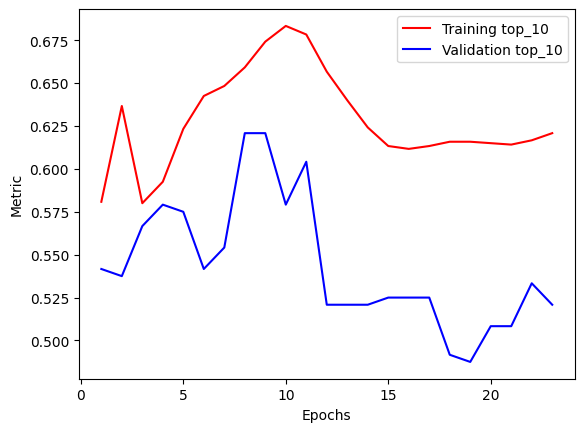

In [30]:
show_metrics(history)

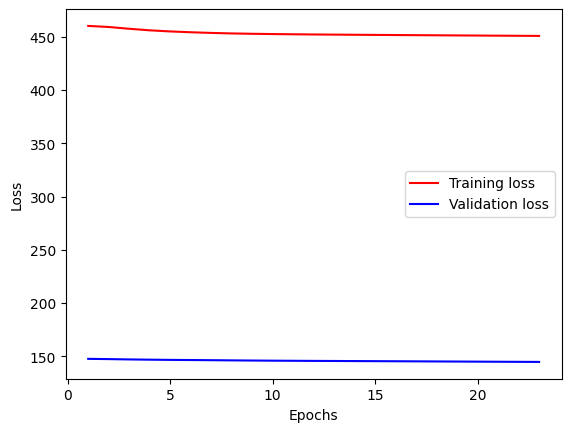

In [31]:
show_loss(history)

In [32]:
model.load_weights(checkpoint_path)

In [33]:
model.predict_reason({"Industry": tf.constant(['Строительство'])})

Наибольший риск:
Нарушение правил дорожного движения
Прочие причины, квалифицированные по материалам расследования несчастных случаев
Нарушение требований безопасности при эксплуатации транспортных средств
Конструктивные недостатки и недостаточная надежность машин, механизмов, оборудования
Недостатки в организации и проведении подготовки работников по охране труда,
Использование пострадавшего не по специальности
Непроведение инструктажа по охране труда
Непроведение обучения и проверки знаний по охране труда
Вследствие необеспеченности ими работодателем
Нахождение пострадавшего в состоянии алкогольного, наркотического и иного токсического опьянения


In [34]:
train_data = np.round(model.evaluate(cached_train, verbose=0)[2], 2)
test_data = np.round(model.evaluate(cached_test, verbose=0)[2], 2)
all_data = np.round(model.evaluate(incidents.batch(100).cache(), verbose=0)[2], 2)
print(f'train {train_data}, test {test_data}, all_data {all_data}')

train 0.72, test 0.62, all_data 0.7


Результат относительно хороший. Из 10 предложений, более половины могут стать причиной несчастного случая 

## Усложнение модели

Для улучшения модели посмотрим что из себя представляют данные и получим дополнительную полезную информацию

Например, можно использовать информацию о поле человека. Явно несчастных случаи у мужчин и женщин различаются, так как их физические возможности различны.

Также полезно было бы узнать статистику несчастных случаев по отраслям

Проделываем такие же операции с данными, добавив пол человека

In [35]:
data = df[['Пол', 'Причина', 'ОКВЭД/отрасль']].rename(columns={'Пол' : 'Sex', 'Причина' : 'Reason', 'ОКВЭД/отрасль' : 'Industry'})
data.head()

,Sex,Reason,Industry
2,муж.,"9, 10, 13",45.21.1
3,муж.,"16, 17",40.10.2
4,муж.,"11, 16",45.21.1
6,муж.,7,65.11
7,муж.,7,74.20.36


In [36]:
Reasons_and_Industries_list = []
for index, row in data.iterrows():
    sex = row[0]
    rsns = str(row[1]).split(', ')
    ind = str(row[2]).split('.')[0]
    ind = find_industry(ind)
    for rsn in rsns:
        Reasons_and_Industries_list.append([sex, rsn, ind])
 

In [37]:
data = pd.DataFrame(Reasons_and_Industries_list, columns = ['Sex', 'Reason', 'Industry'])
data = data[data['Reason'] != '18']
data = data[data['Reason'] != '19']
data = data[data['Reason'] != 'nan']
data = data[data['Industry'] != 'nan']
data.head()

,Sex,Reason,Industry
0,муж.,9,Торговля; Ремонт автотранспорта
1,муж.,10,Торговля; Ремонт автотранспорта
2,муж.,13,Торговля; Ремонт автотранспорта
3,муж.,16,Строительство
4,муж.,17,Строительство


Как видно из статистики, среди причин НС женщины вовсе отсутсвуют, что даст дополнительную информацию для предсказательной модели

<Axes: xlabel='Reason', ylabel='count'>

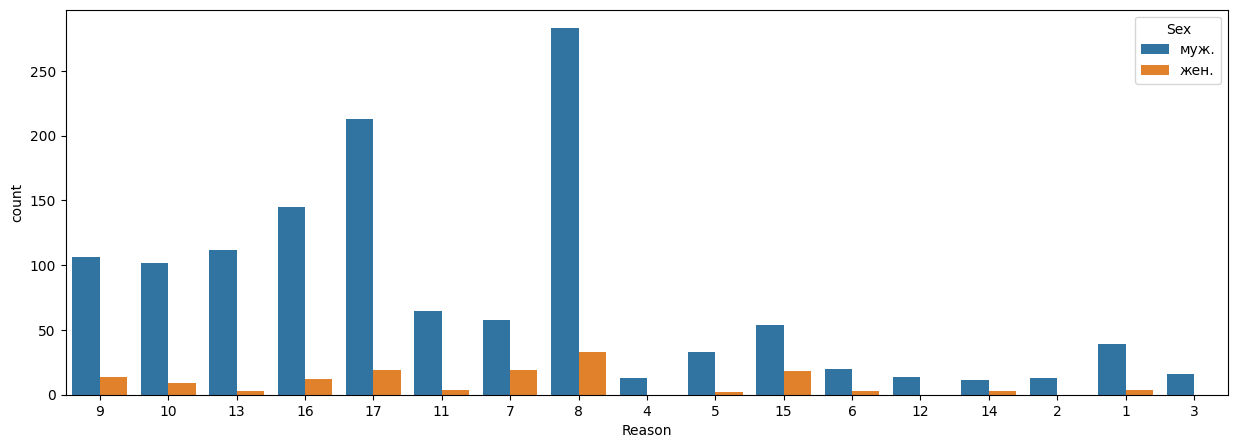

In [38]:
plt.figure(figsize=(15,5))
sns.countplot(data=data, x="Reason", hue="Sex")

Аналогичная ситуация с отраслями.

Стоит отметить, что данная статистика только о смертельных и тяжелых случаях. Поэтому может сложиться ощущение, что строительство и другие отрасли достаточно безопасны. Но это далеко не так, строительство считается одним из самых травмоопасных видов деятельности, просто большинство НС легкие и работадатель предпочитает не сообщать о них в инспекцию труда.

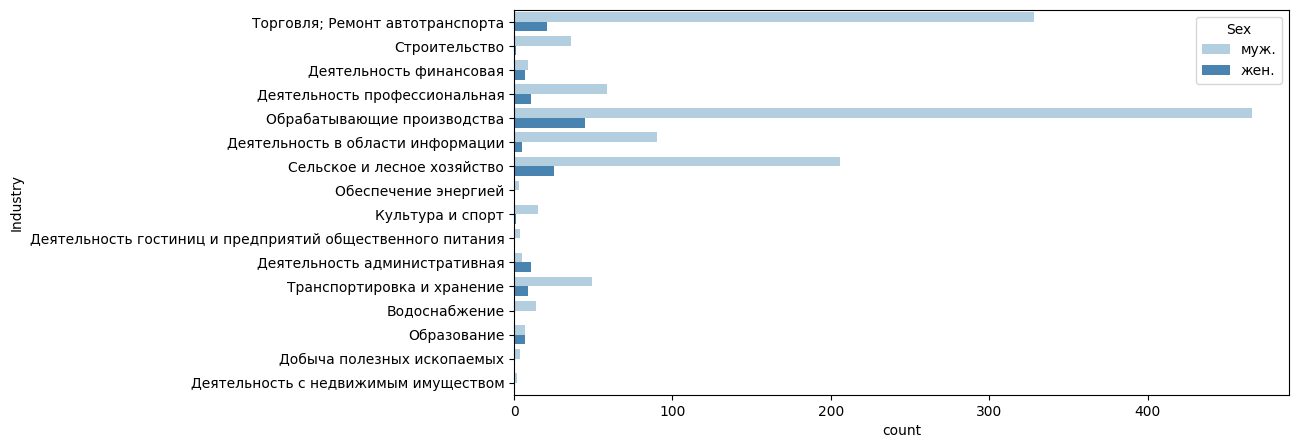

In [39]:
plt.figure(figsize=(10,5))
sns.countplot(y='Industry',data=data,palette='Blues', hue="Sex");

Риск и травматизм понятия постоянные и они всегда присутсвуют в производственной деятельности. Посчитаем количество событий, ставших причинами несчастных случаев. Затем на их основе будем делать предположения об опасности отрасли

In [40]:
incidents_by_industry = data.groupby('Industry', as_index=False).agg({'Reason': 'count'})
incidents_by_industry.head()

,Industry,Reason
0,Водоснабжение,14
1,Деятельность административная,16
2,Деятельность в области информации,95
3,Деятельность гостиниц и предприятий общественн...,4
4,Деятельность профессиональная,70


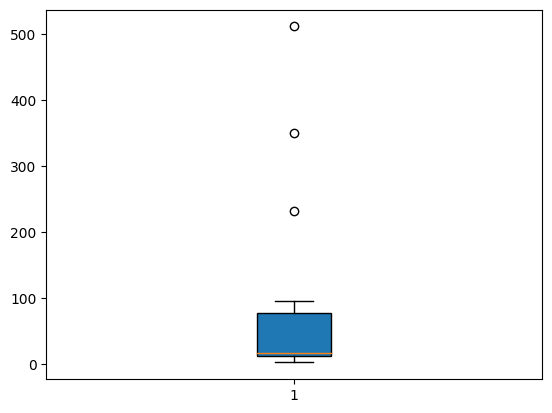

In [41]:
plt.boxplot(incidents_by_industry['Reason'],patch_artist=True);

In [42]:
incidents_by_industry.describe()

,Reason
count,16.000000
mean,90.000000
std,147.545699
min,2.000000
25%,11.500000
50%,16.000000
75%,76.250000
max,511.000000


Количество данных сильно разница от отрасли к отрасли. Для некоторых из них записей недостаточно. Уберем из данных менее травматические отрасли и посмотрим как изменилось распределение данных

In [43]:
not_enough_information = []
for index, row in incidents_by_industry.iterrows():
    if row[1] <= 16:
        not_enough_information.append(row[0])

not_enough_information

['Водоснабжение',
 'Деятельность административная',
 'Деятельность гостиниц и предприятий общественного питания',
 'Деятельность с недвижимым имуществом',
 'Деятельность финансовая',
 'Добыча полезных ископаемых',
 'Культура и спорт',
 'Обеспечение энергией',
 'Образование']

In [44]:
data.shape

(1440, 3)

In [45]:
for industry in not_enough_information:
    data = data[data['Industry'] != industry]

Мы убрали 9 отраслей и 90 записей, что должно повлиять на стабильность предсказаний

In [46]:
data.shape

(1351, 3)

Распределение данных стало лучше, хотя ещё далеко до нормального

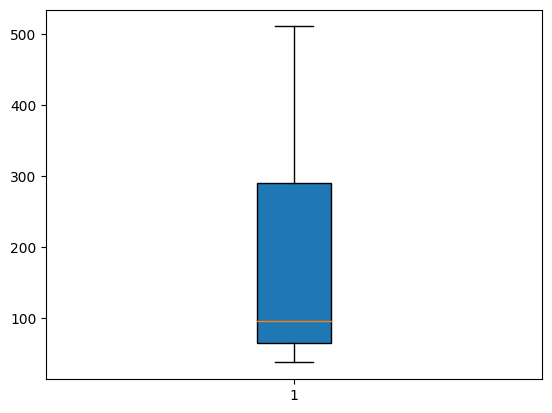

In [47]:
incidents_by_industry = data.groupby('Industry', as_index=False).agg({'Reason': 'count'})
plt.boxplot(incidents_by_industry['Reason'],patch_artist=True);

In [48]:
incidents_by_industry.describe()

,Reason
count,7.000000
mean,193.000000
std,179.906457
min,37.000000
25%,64.000000
50%,95.000000
75%,290.000000
max,511.000000


Определим опасность отрасли на основании имеющихся данных:
* Умеренная опасность - x <= 37
* Средняя опасность - 64 < x <= 95
* Повышенная опасность - 95 < x <= 290
* Экстремальная опасность - 290 < x 

In [49]:
danger_of_industry = {}
for index, row in incidents_by_industry.iterrows():
    if row[1] > 290:
        danger_type = 'Экстремальная опасность'
    elif row[1] > 95:
        danger_type = 'Повышенная опасность'
    elif row[1] > 64:
        danger_type = 'Средняя опасность'
    else:
        danger_type = 'Умеренная опасность'
    danger_of_industry[row[0]] = danger_type
danger_of_industry['Деятельность профессиональная']

'Средняя опасность'

In [50]:
data['Danger'] = data.Industry.apply(lambda x : danger_of_industry[x])
data.head()

,Sex,Reason,Industry,Danger
0,муж.,9,Торговля; Ремонт автотранспорта,Экстремальная опасность
1,муж.,10,Торговля; Ремонт автотранспорта,Экстремальная опасность
2,муж.,13,Торговля; Ремонт автотранспорта,Экстремальная опасность
3,муж.,16,Строительство,Умеренная опасность
4,муж.,17,Строительство,Умеренная опасность


Посмотрим как изменились диаграммы после сокращения данных

<Axes: xlabel='Reason', ylabel='count'>

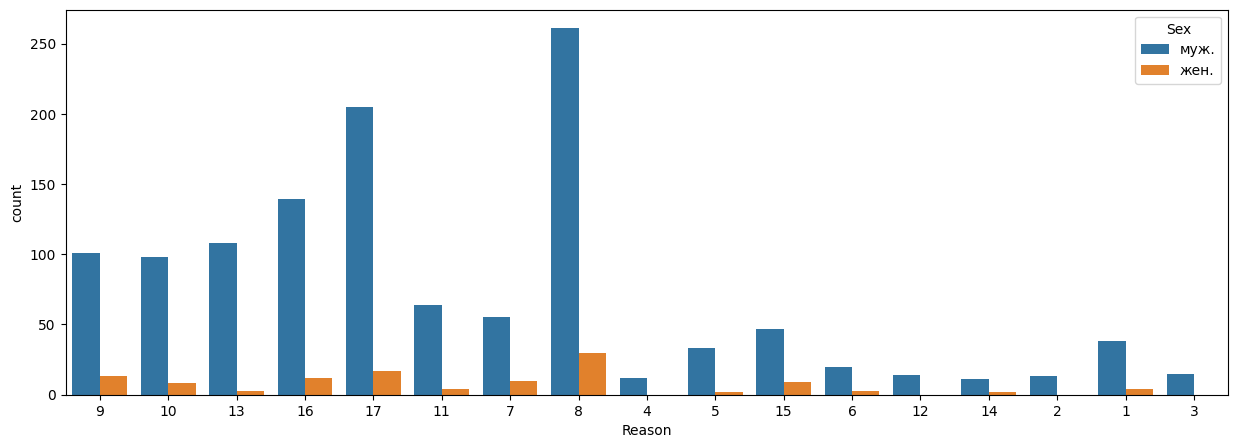

In [51]:
plt.figure(figsize=(15,5))
sns.countplot(data=data, x="Reason", hue="Sex")

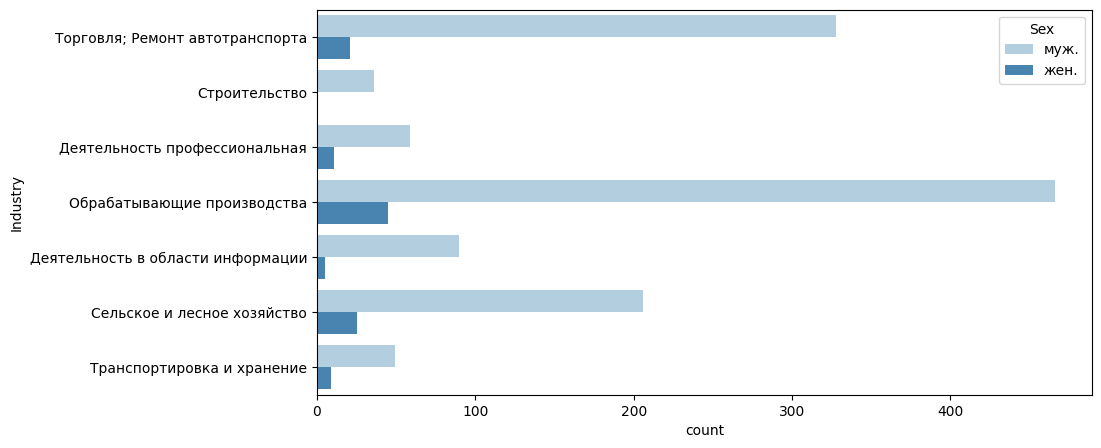

In [52]:
plt.figure(figsize=(10,5))
sns.countplot(y='Industry',data=data,palette='Blues', hue="Sex");

In [53]:
reasons = pd.read_excel('database.xlsx', sheet_name='Коды причин НС', dtype={'Код': str})
reasons.rename(columns={'Наименование причины' : 'Reason_name', 'Код' : 'Reason'}, inplace=True)

Формируем списки всех возможных значений

In [54]:
unique_sex = np.unique(data.Sex)
unique_reasons = np.unique(data.Reason)
unique_industries = np.unique(data.Industry)
unique_dangers = np.unique(data.Danger)

unique_sex, unique_reasons, unique_industries, unique_dangers

(array(['жен.', 'муж.'], dtype=object),
 array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4',
        '5', '6', '7', '8', '9'], dtype=object),
 array(['Деятельность в области информации',
        'Деятельность профессиональная', 'Обрабатывающие производства',
        'Сельское и лесное хозяйство', 'Строительство',
        'Торговля; Ремонт автотранспорта', 'Транспортировка и хранение'],
       dtype=object),
 array(['Повышенная опасность', 'Средняя опасность', 'Умеренная опасность',
        'Экстремальная опасность'], dtype=object))

Формируем датасеты

In [55]:
incidents = tf.data.Dataset.from_tensor_slices(dict(data))
reasons = tf.data.Dataset.from_tensor_slices(dict(reasons))

incidents = incidents.map(lambda x: {
    "Sex": x["Sex"],
    "Reason": x["Reason"],
    "Industry": x["Industry"],
    "Danger": x["Danger"],
})

reasons = reasons.map(lambda x: {"Reason": x["Reason"]})

## Изменение архитектуры сети

Главными изменениями в моделя является:
* Добавление полносвязного слоя на выходе каждой из моделей
* Модель человека принимает на вход пол, отрасль и оценку опасности отрасли

In [95]:
embedding_dim = 8

In [96]:
class ReasonModel(tf.keras.Model):

    def __init__(self, embedding_dim):
        super().__init__()

        reason_input = Input(shape=[], dtype=tf.string, name='Reason')
        reason_lookup = layers.StringLookup(vocabulary=unique_reasons, input_shape=(1,))(reason_input)
        reason_embedding = layers.Embedding(len(unique_reasons) + 1, embedding_dim, input_shape=(1,))(reason_lookup)
        
        dense_1 = layers.Dense(embedding_dim)(reason_embedding)
        
        reason_output = reason_embedding

        
        self.reason_embedding = Model(reason_input, reason_output)
        

    def call(self, inputs):
        return self.reason_embedding(inputs)

In [97]:
reason_model = ReasonModel(8)
reason_model({"Reason": tf.constant(['2'])})

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.04189011, -0.03810091, -0.03081491, -0.018403  , -0.00159103,
         0.01838646, -0.04073786,  0.00194626]], dtype=float32)>

In [98]:
reason_model.reason_embedding.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reason (InputLayer)         [(None,)]                 0         
                                                                 
 string_lookup_16 (StringLoo  (None,)                  0         
 kup)                                                            
                                                                 
 embedding_16 (Embedding)    (None, 8)                 144       
                                                                 
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


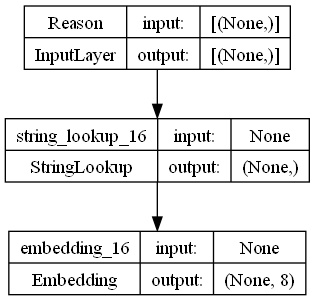

In [99]:
tf.keras.utils.plot_model(reason_model.reason_embedding, show_shapes = True)

In [100]:
class PersonModel(tf.keras.Model):
    def __init__(self, embedding_dim):
        super().__init__()
        
        sex_input = Input(shape=[], dtype=tf.string, name='Sex')
        sex_lookup = layers.StringLookup(vocabulary=unique_sex, input_shape=(1,))(sex_input)
        sex_embedding = layers.Embedding(len(unique_sex) + 1, embedding_dim, input_shape=(1,))(sex_lookup)
        

        industry_input = Input(shape=[], dtype=tf.string, name='Industry')
        industry_lookup = layers.StringLookup(vocabulary=unique_industries, input_shape=(1,))(industry_input)
        industry_embedding = layers.Embedding(len(unique_industries) + 1, embedding_dim, input_shape=(1,))(industry_lookup)
        
        danger_input = Input(shape=[], dtype=tf.string, name='Danger')
        danger_lookup = layers.StringLookup(vocabulary=unique_dangers, input_shape=(1,))(danger_input)
        danger_embedding = layers.Embedding(len(unique_dangers) + 1, embedding_dim, input_shape=(1,))(danger_lookup)
        
        concatenated = layers.Concatenate()([sex_embedding, industry_embedding, danger_embedding])
        
        
        dense_1 = layers.Dense(3 * embedding_dim, activation="relu")(concatenated)
        dense_2 = layers.Dense(embedding_dim)(dense_1)
        
        
        person_output = dense_2

        
        self.person_embedding = Model([sex_input, industry_input, danger_input], person_output)

    def call(self, inputs):
        return self.person_embedding(inputs)

In [101]:
person_model = PersonModel(8)
person_model({"Sex": tf.constant(['муж.']),
              "Industry": tf.constant(['Торговля; Ремонт автотранспорта']),
              'Danger' : tf.constant(['Экстремальная опасность'])})

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.00759243, -0.04458981,  0.00038589,  0.04751556,  0.01840895,
        -0.00949424, -0.01605492,  0.03939007]], dtype=float32)>

In [102]:
person_model.person_embedding.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sex (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 Industry (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 Danger (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 string_lookup_17 (StringLookup  (None,)             0           ['Sex[0][0]']                    
 )                                                                                         

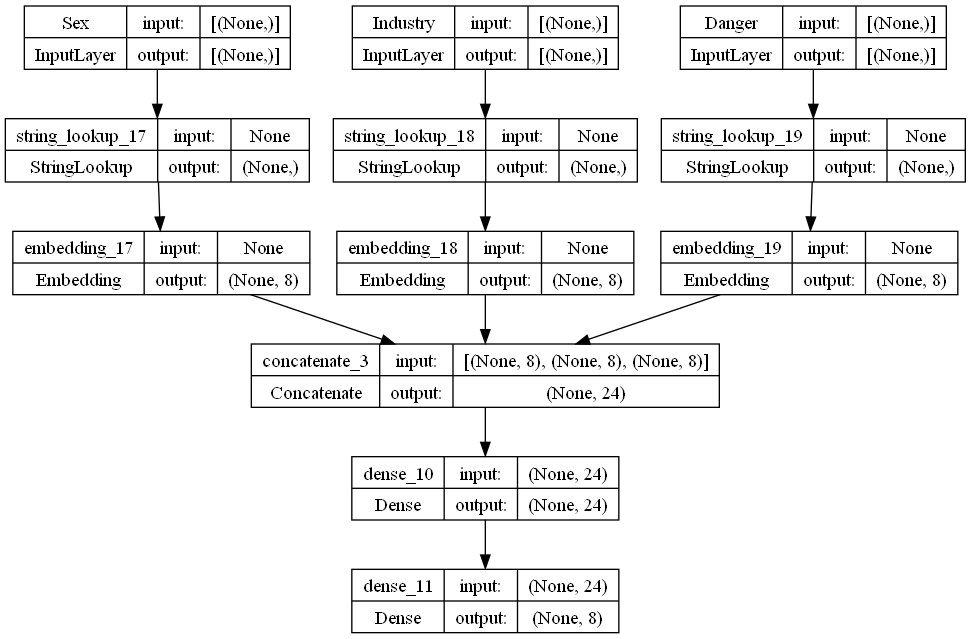

In [103]:
tf.keras.utils.plot_model(person_model.person_embedding, show_shapes = True)

In [104]:
class AccidentModel(tfrs.Model):

    def __init__(self, embedding_dim):
        super().__init__()

        self.reason_model = ReasonModel(embedding_dim)

        self.person_model = PersonModel(embedding_dim)

        self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=reasons.batch(10).map(self.reason_model),
        ),
    )
        
    def call(self, features) -> tf.Tensor:

        person_embeddings = self.person_model({"Sex": features["Sex"],
                                               "Industry": features["Industry"],
                                               "Danger": features["Danger"]})

        reason_embeddings = self.reason_model({"Reason": features["Reason"]})

        return person_embeddings, reason_embeddings

    def compute_loss(self, features, training=False):

        person_embeddings, positive_reason_embeddings = self.call(features)

        return self.task(person_embeddings, positive_reason_embeddings)
    
    def predict_reason(self, person):
        index = tfrs.layers.factorized_top_k.BruteForce(self.person_model)
        index.index_from_dataset(
            tf.data.Dataset.zip((reasons.batch(128).map(lambda x: x["Reason"]),
                                 reasons.batch(128).map(self.reason_model)))
            )
        query = person
        _, rsns = index(query)
        result = []
        print(f"Наиболее вероятными причинами несчастного случая для работника являются:")
        for i, res in enumerate(rsns[0].numpy()):
            print(i + 1, reasons_dict[res.decode()])
    

In [105]:
data_size = len(incidents)
data_size 

1351

In [106]:
tf.random.set_seed(15)
shuffled = incidents.take(data_size).shuffle(data_size, seed=15, reshuffle_each_iteration=False)

train = shuffled.take(1200)
test = shuffled.skip(1200).take(data_size - 1200)

cached_train = train.batch(100).cache() 
cached_test = test.batch(100).cache()

## Подбор гиперпараметров

Найдем оптимальные параметры путем прогона данных через нейронную сеть

In [136]:
from tqdm import tqdm

In [140]:
emb_dim_list = [4, 8, 12]
emb_dim_dict = {4 : {'train' : np.zeros(30), 'test' : np.zeros(30)},
                8 : {'train' : np.zeros(30), 'test' : np.zeros(30)},
                12 : {'train' : np.zeros(30), 'test' : np.zeros(30)}
               }

In [141]:
emb_dim_dict[4]['train']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [142]:
for emb_dim in emb_dim_list:
    for _ in tqdm(range(10)):
        model = AccidentModel(emb_dim)
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-2))
        with tf.device(tf.test.gpu_device_name()):
            history = model.fit(cached_train,
                                epochs=30,
                                validation_data=cached_test,
                                verbose=0
                               )
        his = history.history
        emb_dim_dict[emb_dim]['train'] +=  his['factorized_top_k/top_10_categorical_accuracy']
        emb_dim_dict[emb_dim]['test'] +=  his['val_factorized_top_k/top_10_categorical_accuracy']
    print(f'Закончен прогон с размерностью {emb_dim}')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:28<00:00, 20.85s/it]


Закончен прогон с размерностью 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:22<00:00, 20.30s/it]


Закончен прогон с размерностью 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:23<00:00, 20.33s/it]

Закончен прогон с размерностью 12


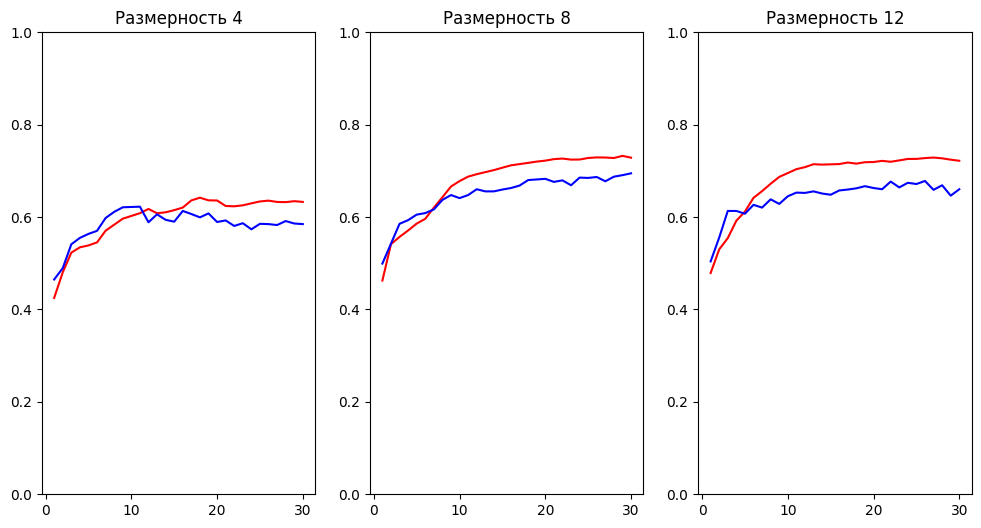

In [144]:
epochs = range(1, 31)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,figsize=(12, 6))

ax0.set_title('Размерность 4')
ax0.plot(epochs, emb_dim_dict[4]['train'] / 10, 'r', label='Training accuracy', scaley=False)
ax0.plot(epochs, emb_dim_dict[4]['test'] / 10, 'b', label='Validation accuracy', scaley=False)

ax1.set_title('Размерность 8')
ax1.plot(epochs, emb_dim_dict[8]['train'] / 10, 'r', label='Training accuracy', scaley=False)
ax1.plot(epochs, emb_dim_dict[8]['test'] / 10, 'b', label='Validation accuracy', scaley=False)

ax2.set_title('Размерность 12')
ax2.plot(epochs, emb_dim_dict[12]['train'] / 10, 'r', label='Training accuracy', scaley=False)
ax2.plot(epochs, emb_dim_dict[12]['test'] / 10, 'b', label='Validation accuracy', scaley=False)

plt.show()

In [149]:
lr_list = [1e-1, 1e-2, 1e-3]
lr_dict = {1e-1 : {'train' : np.zeros(30), 'test' : np.zeros(30)},
           1e-2 : {'train' : np.zeros(30), 'test' : np.zeros(30)},
           1e-3 : {'train' : np.zeros(30), 'test' : np.zeros(30)}
          }

for lr in lr_list:
    for _ in tqdm(range(10)):
        model = AccidentModel(8)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr))
        with tf.device(tf.test.gpu_device_name()):
            history = model.fit(cached_train,
                                epochs=30,
                                validation_data=cached_test,
                                verbose=0
                               )
        his = history.history
        lr_dict[lr]['train'] +=  his['factorized_top_k/top_10_categorical_accuracy']
        lr_dict[lr]['test'] +=  his['val_factorized_top_k/top_10_categorical_accuracy']
    print(f'Закончен прогон со скоростью обучения {lr}')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:32<00:00, 21.22s/it]


Закончен прогон со скоростью обучения 0.1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:27<00:00, 20.74s/it]


Закончен прогон со скоростью обучения 0.01


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:24<00:00, 20.45s/it]

Закончен прогон со скоростью обучения 0.001


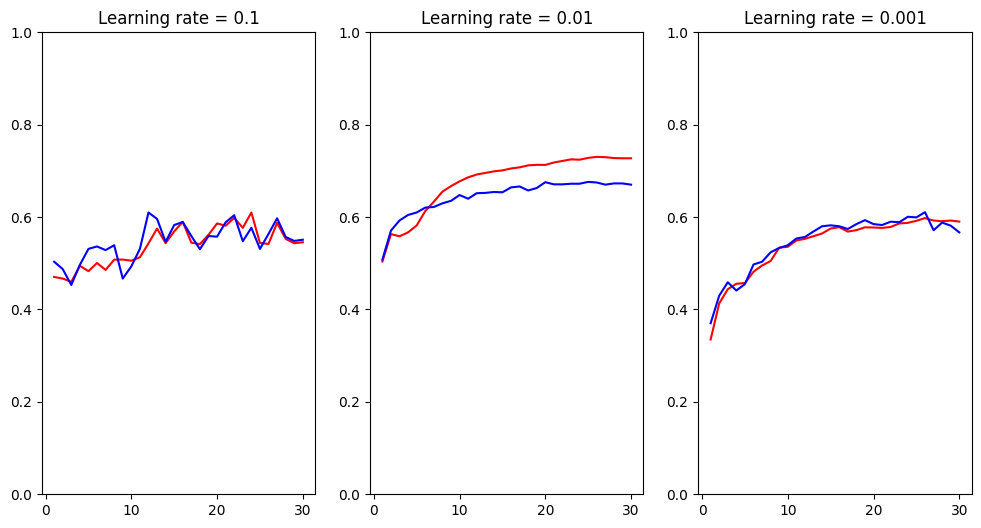

In [150]:
epochs = range(1, 31)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,figsize=(12, 6))

ax0.set_title('Learning rate = 0.1')
ax0.plot(epochs, lr_dict[1e-1]['train'] / 10, 'r', label='Training accuracy', scaley=False)
ax0.plot(epochs, lr_dict[1e-1]['test'] / 10, 'b', label='Validation accuracy', scaley=False)

ax1.set_title('Learning rate = 0.01')
ax1.plot(epochs, lr_dict[1e-2]['train'] / 10, 'r', label='Training accuracy', scaley=False)
ax1.plot(epochs, lr_dict[1e-2]['test'] / 10, 'b', label='Validation accuracy', scaley=False)

ax2.set_title('Learning rate = 0.001')
ax2.plot(epochs, lr_dict[1e-3]['train'] / 10, 'r', label='Training accuracy', scaley=False)
ax2.plot(epochs, lr_dict[1e-3]['test'] / 10, 'b', label='Validation accuracy', scaley=False)

plt.show()

In [78]:
#del model
model = AccidentModel() 
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2))

In [69]:
checkpoint_path = "advance_acciden_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_factorized_top_k/top_10_categorical_accuracy',
        #monitor='val_loss',
        patience=20
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_factorized_top_k/top_10_categorical_accuracy',
        #monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1)
]

In [70]:
with tf.device(tf.test.gpu_device_name()):
    history = model.fit(cached_train,
              epochs=100,
              validation_data=cached_test,
              callbacks=callbacks_list)

Epoch 1/100
12/12 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0017 - factorized_top_k/top_5_categorical_accuracy: 0.1808 - factorized_top_k/top_10_categorical_accuracy: 0.4908 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 460.4545 - regularization_loss: 0.0000e+00 - total_loss: 460.4545    
Epoch 1: val_factorized_top_k/top_10_categorical_accuracy improved from -inf to 0.59603, saving model to advance_acciden_model\cp.ckpt
12/12 [==============================] - 2s 88ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0017 - factorized_top_k/top_5_categorical_accuracy: 0.1808 - factorized_top_k/top_10_categorical_accuracy: 0.4908 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 460.4405 - regularization_loss: 0.0000e+00 - total_loss: 460.4405 - val_factorized_top_k/top_1_categorical_accuracy:

12/12 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0092 - factorized_top_k/top_5_categorical_accuracy: 0.2233 - factorized_top_k/top_10_categorical_accuracy: 0.6783 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 456.4523 - regularization_loss: 0.0000e+00 - total_loss: 456.4523
Epoch 7: val_factorized_top_k/top_10_categorical_accuracy did not improve from 0.65563
12/12 [==============================] - 1s 60ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0092 - factorized_top_k/top_5_categorical_accuracy: 0.2233 - factorized_top_k/top_10_categorical_accuracy: 0.6783 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 456.1372 - regularization_loss: 0.0000e+00 - total_loss: 456.1372 - val_factorized_top_k/top_1_categorical_accuracy: 0.0066 - val_factorized_top_k/top_5_categorical_accuracy: 0.278

12/12 [==============================] - 1s 63ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0083 - factorized_top_k/top_5_categorical_accuracy: 0.2567 - factorized_top_k/top_10_categorical_accuracy: 0.7275 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 454.9425 - regularization_loss: 0.0000e+00 - total_loss: 454.9425 - val_factorized_top_k/top_1_categorical_accuracy: 0.0132 - val_factorized_top_k/top_5_categorical_accuracy: 0.2914 - val_factorized_top_k/top_10_categorical_accuracy: 0.7020 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 204.2346 - val_regularization_loss: 0.0000e+00 - val_total_loss: 204.2346
Epoch 14/100
12/12 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0092 - factorized_top_k/top_5_categorical_accuracy: 0.2442 - factorized_top_k/top_10_categorical_accuracy: 

Epoch 20/100
11/12 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0109 - factorized_top_k/top_5_categorical_accuracy: 0.2591 - factorized_top_k/top_10_categorical_accuracy: 0.7355 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 454.7109 - regularization_loss: 0.0000e+00 - total_loss: 454.7109
Epoch 20: val_factorized_top_k/top_10_categorical_accuracy did not improve from 0.70199
12/12 [==============================] - 1s 56ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0100 - factorized_top_k/top_5_categorical_accuracy: 0.2692 - factorized_top_k/top_10_categorical_accuracy: 0.7392 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 454.1887 - regularization_loss: 0.0000e+00 - total_loss: 454.1887 - val_factorized_top_k/top_1_categorical_accuracy: 0.0066 - val_factorized_top_k/top_5_categorical_a

Epoch 27/100
11/12 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0091 - factorized_top_k/top_5_categorical_accuracy: 0.2273 - factorized_top_k/top_10_categorical_accuracy: 0.7400 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 454.2760 - regularization_loss: 0.0000e+00 - total_loss: 454.2760
Epoch 27: val_factorized_top_k/top_10_categorical_accuracy did not improve from 0.70199
12/12 [==============================] - 1s 59ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0083 - factorized_top_k/top_5_categorical_accuracy: 0.2300 - factorized_top_k/top_10_categorical_accuracy: 0.7408 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 453.8153 - regularization_loss: 0.0000e+00 - total_loss: 453.8153 - val_factorized_top_k/top_1_categorical_accuracy: 0.0066 - val_factorized_top_k/top_5_categorical_a

12/12 [==============================] - 1s 58ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0083 - factorized_top_k/top_5_categorical_accuracy: 0.2300 - factorized_top_k/top_10_categorical_accuracy: 0.7475 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 453.5192 - regularization_loss: 0.0000e+00 - total_loss: 453.5192 - val_factorized_top_k/top_1_categorical_accuracy: 0.0066 - val_factorized_top_k/top_5_categorical_accuracy: 0.2583 - val_factorized_top_k/top_10_categorical_accuracy: 0.6623 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 203.9747 - val_regularization_loss: 0.0000e+00 - val_total_loss: 203.9747
Epoch 34/100
12/12 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0075 - factorized_top_k/top_5_categorical_accuracy: 0.2225 - factorized_top_k/top_10_categorical_accuracy: 

Epoch 40/100
11/12 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0073 - factorized_top_k/top_5_categorical_accuracy: 0.2155 - factorized_top_k/top_10_categorical_accuracy: 0.7345 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 453.6643 - regularization_loss: 0.0000e+00 - total_loss: 453.6643
Epoch 40: val_factorized_top_k/top_10_categorical_accuracy did not improve from 0.71523
12/12 [==============================] - 1s 58ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0067 - factorized_top_k/top_5_categorical_accuracy: 0.2150 - factorized_top_k/top_10_categorical_accuracy: 0.7342 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 453.2616 - regularization_loss: 0.0000e+00 - total_loss: 453.2616 - val_factorized_top_k/top_1_categorical_accuracy: 0.0066 - val_factorized_top_k/top_5_categorical_a

Epoch 47/100
11/12 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0064 - factorized_top_k/top_5_categorical_accuracy: 0.2118 - factorized_top_k/top_10_categorical_accuracy: 0.7345 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 453.4800 - regularization_loss: 0.0000e+00 - total_loss: 453.4800
Epoch 47: val_factorized_top_k/top_10_categorical_accuracy did not improve from 0.71523
12/12 [==============================] - 1s 56ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy: 0.2117 - factorized_top_k/top_10_categorical_accuracy: 0.7350 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 453.1172 - regularization_loss: 0.0000e+00 - total_loss: 453.1172 - val_factorized_top_k/top_1_categorical_accuracy: 0.0066 - val_factorized_top_k/top_5_categorical_a

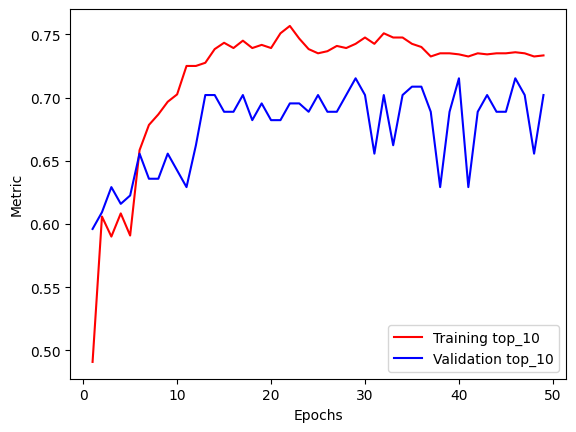

In [71]:
show_metrics(history)

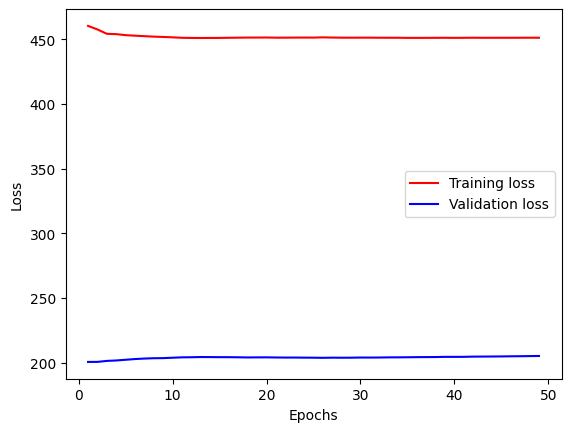

In [72]:
show_loss(history)

In [79]:
model.load_weights(checkpoint_path)

In [82]:
model.predict_reason({"Sex": tf.constant(['муж.']),
                      "Industry": tf.constant(['Деятельность профессиональная']),
                      'Danger' : tf.constant(['Средняя опасность'])})

Наиболее вероятными причинами несчастного случая для работника являются:
1 Нарушение правил дорожного движения
2 Эксплуатация неисправных машин, механизмов, оборудования
3 Несовершенство технологического процесса
4 Прочие причины, квалифицированные по материалам расследования несчастных случаев
5 Нарушение технологического процесса
6 Нарушение требований безопасности при эксплуатации транспортных средств
7 Конструктивные недостатки и недостаточная надежность машин, механизмов, оборудования
8 Нарушение работником трудового распорядка и дисциплины труда, в т.ч.
9 Недостаточный контроль со стороны должностных лиц 
10 Неудовлетворительная организация производства работ


In [83]:
model.predict_reason({"Sex": tf.constant(['жен.']),
                      "Industry": tf.constant(['Обрабатывающие производства']),
                      'Danger' : tf.constant(['Экстремальная опасность'])})

Наиболее вероятными причинами несчастного случая для работника являются:
1 Использование пострадавшего не по специальности
2 Прочие причины, квалифицированные по материалам расследования несчастных случаев
3 Нарушение требований безопасности при эксплуатации транспортных средств
4 Неудовлетворительная организация производства работ
5 Неудовлетворительное содержание и недостатки в организации рабочих мест
6 Неприменение работником средств индивидуальной защиты
7 Конструктивные недостатки и недостаточная надежность машин, механизмов, оборудования
8 Недостатки в организации и проведении подготовки работников по охране труда,
9 Нарушение работником ИОТ
10 Недостаточный контроль со стороны должностных лиц 


In [ ]:
train_data = np.round(model.evaluate(cached_train, verbose=0)[2], 2)
test_data = np.round(model.evaluate(cached_test, verbose=0)[2], 2)
all_data = np.round(model.evaluate(incidents.batch(100).cache(), verbose=0)[2], 2)
print(f'train {train_data}, test {test_data}, all_data {all_data}')